<a href="https://colab.research.google.com/github/schrodinger95/SI650-Project/blob/main/SI650_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade fastrank lightgbm==3.1.1
!pip install python-terrier

In [ ]:
import pyterrier as pt
import pandas as pd
import os

In [ ]:
if not pt.started():
    pt.init()

In [ ]:
df = pd.read_csv('final_documents.csv') 
df['docno'] = df.docno.astype(str)
df['rating'] = df.rating.astype(str)
df['review_text_1'] = df.review_text_1.astype(str)
df['review_time_1'] = df.review_time_1.astype(str)
df['review_text_2'] = df.review_text_2.astype(str)
df['review_time_2'] = df.review_time_2.astype(str)
df['review_text_3'] = df.review_text_3.astype(str)
df['review_time_3'] = df.review_time_3.astype(str)
df['review_text_4'] = df.review_text_4.astype(str)
df['review_time_4'] = df.review_time_4.astype(str)
df['review_text_5'] = df.review_text_5.astype(str)
df['review_time_5'] = df.review_time_5.astype(str)
df.head()

,docno,place_id,name,map_name,state,lat,lng,title,description,rating,review_text_1,review_time_1,review_text_2,review_time_2,review_text_3,review_time_3,review_text_4,review_time_4,review_text_5,review_time_5
0,1,ChIJ_VVXImAMyFYRnus7r5Dykqs,26 Glacier Cruise,26 Glacier Cruise,Alaska,60.777823,-148.697484,"26 Glacier Cruise - Whittier, Alaska - Alaska ...",26 Glacier Cruise takes passengers around the ...,4.8,Fantastic experience! The pictures attached to...,1636781828.0,The cruise so worth and highly recommend if an...,1630602901.0,Booked the 26 Glaciers but changed to the shor...,1629765328.0,One of our best tour experiences during our vi...,1626901581.0,OMG! My family and I had an amazing Time on th...,1626768663.0
1,2,ChIJH0jnvSmWyFYRXV2yOkGp6Ac,5th Avenue Mall,Anchorage 5th Avenue Mall,Alaska,61.216889,-149.888942,"5th Avenue Mall - Anchorage, Alaska - Shopping...",5th Avenue Mall is located at West 5th Avenue ...,4.2,"While there are many vacancies currently, this...",1636418825.0,Pretty good... I haven't been here for years. ...,1637807843.0,Visited my favorite shoe store (The Alaska Wal...,1619913101.0,Location is prime. This place has the best loc...,1626155621.0,I truly value my bi-weekly visits here! The su...,1636152161.0
2,3,ChIJyYLv3YLfAFQRwdhiwYC5zcQ,A Gallery in Juneau,Juneau Artists Gallery Ltd,Alaska,58.300215,-134.404656,A Gallery in Juneau,"Like many cities in Alaska, Juneau has numerou...",4.5,"Great assortment of local artist works, with a...",1638149268.0,Great place for local artists.,1636178619.0,Great local artwork and jewelry. Stop in and ...,1554835391.0,This store sells locally crafted items such as...,1518289597.0,Visited while on vacation fun place,1506443215.0
3,4,ChIJjUPnbCmWyFYRr_lSUBrKRVc,A Part of the Anchorage Museum,Anchorage Museum,Alaska,61.216228,-149.885579,A Part of the Anchorage Museum,The Rasmussen Center is the portion of the Anc...,4.5,Shockingly wonderful! We had a great experienc...,1634888805.0,The Anchorage Museum was fantastic! We were fo...,1637977833.0,One of the more culturally and globally aware ...,1638073297.0,"A very good regional museum, encompassing art,...",1629402829.0,The exterior and interior design of the museum...,1632588328.0
4,5,ChIJhbwvNU97yFYRtKJsGzJuMXw,"A Rugged, But Beautiful Adventure",Alaska Wildland Adventures,Alaska,60.961173,-149.145260,"A Rugged, But Beautiful Adventure",Switchback Trail is a hiking trail not for the...,4.3,We recently stayed at the Kenai Fjords Glacier...,1629992829.0,"Everything is top-notch, A1 here! Guides are f...",1622805819.0,Awesome day of guided fishing on the Upper Ken...,1536624163.0,Beautiful lodges in spectacular locations with...,1532641243.0,A great company to work for!,1555657216.0


In [ ]:
pd_indexer = pt.DFIndexer("./pd_index", overwrite=True, blocks=True)
indexref = pd_indexer.index(df["description"], df["docno"], 
                            df["map_name"], df["title"], df["rating"], 
                            df["review_text_1"], df["review_time_1"],
                            df["review_text_2"], df["review_time_2"],
                            df["review_text_3"], df["review_time_3"],
                            df["review_text_4"], df["review_time_4"],
                            df["review_text_5"], df["review_time_5"],)

In [ ]:
index = pt.IndexFactory.of(indexref)
print(index.getCollectionStatistics().toString())

Number of documents: 13891
Number of terms: 42016
Number of postings: 1855998
Number of fields: 0
Number of tokens: 2708372
Field names: []
Positions:   true



In [ ]:
topics = pd.read_csv('Query.csv') 
topics['qid'] = topics.qid.astype('str')
topics.head()

,qid,query
0,1,A place where you can see various kinds of ani...
1,2,A park with trees everywhere
2,3,A beautiful place with waterfalls
3,4,A playground suitable for family entertainment
4,5,A city with many art-focused museums


In [ ]:
qrels = pd.read_csv('qrel.csv') 
qrels['qid'] = qrels.qid.astype(str)
qrels['docno'] = qrels.docno.astype(str)
qrels.head()

,qid,docno,label
0,1,9837,5
1,1,572,5
2,1,12369,5
3,1,4629,5
4,1,811,5


In [ ]:
tf = pt.BatchRetrieve(index, wmodel="Tf")
tf_idf = pt.BatchRetrieve(index, wmodel="TF_IDF")
bm25 = pt.BatchRetrieve(index, wmodel="BM25")
br = pt.BatchRetrieve(index)
sdm = pt.rewrite.SDM()
qe = pt.rewrite.Bo1QueryExpansion(index)

In [ ]:
RANK_CUTOFF = 10
SEED=42

from sklearn.model_selection import train_test_split

tr_va_topics, test_topics = train_test_split(topics, test_size=9, random_state=SEED)
train_topics, valid_topics = train_test_split(tr_va_topics, test_size=3, random_state=SEED)

In [ ]:
ltr_feats = (bm25 % RANK_CUTOFF) >> pt.text.get_text(index, ["map_name", 
                                                             "title", 
                                                             "rating", 
                                                             "review_text_1",
                                                             "review_time_1",
                                                             "review_text_2",
                                                             "review_time_2",
                                                             "review_text_3",
                                                             "review_time_3",
                                                             "review_text_4",
                                                             "review_time_4",
                                                             "review_text_5",
                                                             "review_time_5"]) >> (
    pt.transformer.IdentityTransformer()
    ** # sequential dependence
    (sdm >> bm25)
    ** # score of map_name
    (pt.text.scorer(body_attr="map_name", wmodel='BM25') ) 
    ** # score of title
    (pt.text.scorer(body_attr="title", wmodel='BM25') ) 
    ** # rating
    (pt.apply.doc_score(lambda row: 0 if row["rating"]=="nan" else float(row["rating"])))
    ** # score of reviews
    (pt.text.scorer(body_attr="review_text_1", wmodel='BM25') + 
     pt.text.scorer(body_attr="review_text_2", wmodel='BM25') +
     pt.text.scorer(body_attr="review_text_3", wmodel='BM25') +
     pt.text.scorer(body_attr="review_text_4", wmodel='BM25') +
     pt.text.scorer(body_attr="review_text_5", wmodel='BM25') )
)
                                                             
# for reference, lets record the feature names here too
fnames=["BM25", "SDM", "map_name", "title", "rating", "reviews"]

In [ ]:
pt.Experiment(
    [ltr_feats >> pt.ltr.feature_to_score(i) for i in range(len(fnames))],
    test_topics,
    qrels, 
    names=fnames,
    eval_metrics=["map", "ndcg", "ndcg_cut_10", "num_rel_ret"])

20:27:36.967 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:27:37.167 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:27:37.398 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:27:37.613 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from CombSumTransformer(CombSumTransformer(CombSumTransformer(CombSumTransformer(<pyterrier.batchretrieve.TextScorer object at 0x7f9234071790>, <pyterrier.batchretrieve.TextScorer object at 0x7f92340717d0>), <pyterrier.batchretrieve.TextScorer object at 0x7f9234071710>), <pyterrier.batchretrieve.TextScorer object at 0x7f9234071810>), <pyterrier.batchretrieve.TextScorer object at 0x7f9234071890>), expected 90 received 2, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


20:27:42.280 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:27:42.442 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:27:42.694 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:27:42.882 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from CombSumTransformer(CombSumTransformer(CombSumTransformer(CombSumTransformer(<pyterrier.batchretrieve.TextScorer object at 0x7f9234071790>, <pyterrier.batchretrieve.TextScorer object at 0x7f92340717d0>), <pyterrier.batchretrieve.TextScorer object at 0x7f9234071710>), <pyterrier.batchretrieve.TextScorer object at 0x7f9234071810>), <pyterrier.batchretrieve.TextScorer object at 0x7f9234071890>), expected 90 received 2, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


20:27:47.387 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:27:47.583 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:27:47.806 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:27:47.985 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from CombSumTransformer(CombSumTransformer(CombSumTransformer(CombSumTransformer(<pyterrier.batchretrieve.TextScorer object at 0x7f9234071790>, <pyterrier.batchretrieve.TextScorer object at 0x7f92340717d0>), <pyterrier.batchretrieve.TextScorer object at 0x7f9234071710>), <pyterrier.batchretrieve.TextScorer object at 0x7f9234071810>), <pyterrier.batchretrieve.TextScorer object at 0x7f9234071890>), expected 90 received 2, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


20:27:52.398 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:27:52.549 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:27:52.732 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:27:52.893 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from CombSumTransformer(CombSumTransformer(CombSumTransformer(CombSumTransformer(<pyterrier.batchretrieve.TextScorer object at 0x7f9234071790>, <pyterrier.batchretrieve.TextScorer object at 0x7f92340717d0>), <pyterrier.batchretrieve.TextScorer object at 0x7f9234071710>), <pyterrier.batchretrieve.TextScorer object at 0x7f9234071810>), <pyterrier.batchretrieve.TextScorer object at 0x7f9234071890>), expected 90 received 2, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


20:27:57.182 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:27:57.324 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:27:57.506 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:27:57.691 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from CombSumTransformer(CombSumTransformer(CombSumTransformer(CombSumTransformer(<pyterrier.batchretrieve.TextScorer object at 0x7f9234071790>, <pyterrier.batchretrieve.TextScorer object at 0x7f92340717d0>), <pyterrier.batchretrieve.TextScorer object at 0x7f9234071710>), <pyterrier.batchretrieve.TextScorer object at 0x7f9234071810>), <pyterrier.batchretrieve.TextScorer object at 0x7f9234071890>), expected 90 received 2, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


20:28:02.000 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:28:02.160 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:28:02.325 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:28:02.493 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from CombSumTransformer(CombSumTransformer(CombSumTransformer(CombSumTransformer(<pyterrier.batchretrieve.TextScorer object at 0x7f9234071790>, <pyterrier.batchretrieve.TextScorer object at 0x7f92340717d0>), <pyterrier.batchretrieve.TextScorer object at 0x7f9234071710>), <pyterrier.batchretrieve.TextScorer object at 0x7f9234071810>), <pyterrier.batchretrieve.TextScorer object at 0x7f9234071890>), expected 90 received 2, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


,name,map,ndcg,ndcg_cut_10,num_rel_ret
0,BM25,0.071299,0.267589,0.650166,63.0
1,SDM,0.071373,0.269243,0.654094,63.0
2,map_name,0.068581,0.255908,0.621646,63.0
3,title,0.070335,0.259121,0.629595,63.0
4,rating,0.069812,0.255289,0.620082,63.0
5,reviews,0.067915,0.254694,0.618563,63.0


In [ ]:
ca_qrels = qrels.copy()
ca_qrels['label']=ca_qrels.label.astype(float)
ca_qrels.head()

,qid,docno,label
0,1,9837,5.0
1,1,572,5.0
2,1,12369,5.0
3,1,4629,5.0
4,1,811,5.0


In [ ]:
import fastrank

train_request = fastrank.TrainRequest.coordinate_ascent()

params = train_request.params
params.init_random = True
params.normalize = True
params.seed = 1234567

ca_pipe = ltr_feats >> pt.ltr.apply_learned_model(train_request, form='fastrank')

%time ca_pipe.fit(train_topics, ca_qrels)

20:40:33.687 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:40:33.956 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:40:34.177 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:40:34.403 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from CombSumTransformer(CombSumTransformer(CombSumTransformer(CombSumTransformer(<pyterrier.batchretrieve.TextScorer object at 0x7f9234071790>, <pyterrier.batchretrieve.TextScorer object at 0x7f92340717d0>), <pyterrier.batchretrieve.TextScorer object at 0x7f9234071710>), <pyterrier.batchretrieve.TextScorer object at 0x7f9234071810>), <pyterrier.batchretrieve.TextScorer object at 0x7f9234071890>), expected 180 received 13, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))
/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer

CPU times: user 9.55 s, sys: 205 ms, total: 9.75 s
Wall time: 8.44 s


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=400, verbose=1, random_state=SEED, n_jobs=2)

rf_pipe = ltr_feats >> pt.ltr.apply_learned_model(rf)

%time rf_pipe.fit(train_topics, qrels)

20:56:07.576 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:56:07.788 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:56:08.074 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:56:08.309 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from CombSumTransformer(CombSumTransformer(CombSumTransformer(CombSumTransformer(<pyterrier.batchretrieve.TextScorer object at 0x7f9234071790>, <pyterrier.batchretrieve.TextScorer object at 0x7f92340717d0>), <pyterrier.batchretrieve.TextScorer object at 0x7f9234071710>), <pyterrier.batchretrieve.TextScorer object at 0x7f9234071810>), <pyterrier.batchretrieve.TextScorer object at 0x7f9234071890>), expected 180 received 13, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))
/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer

CPU times: user 9.37 s, sys: 233 ms, total: 9.6 s
Wall time: 8.87 s


[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.6s finished


In [ ]:
import lightgbm as lgb

# this configures LightGBM as LambdaMART
lmart_l = lgb.LGBMRanker(
    task="train",
    silent=False,
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=1,
    max_bin=255,
    num_leaves=31,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[10],
    ndcg_at=[10],
    eval_at=[10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=100,
    early_stopping_rounds=5
)

lmart_x_pipe = ltr_feats >> pt.ltr.apply_learned_model(lmart_l, form="ltr", fit_kwargs={'eval_at':[10]})

%time lmart_x_pipe.fit(train_topics, qrels, valid_topics, qrels)

20:56:16.364 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:56:16.562 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:56:16.813 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:56:17.046 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from CombSumTransformer(CombSumTransformer(CombSumTransformer(CombSumTransformer(<pyterrier.batchretrieve.TextScorer object at 0x7f9234071790>, <pyterrier.batchretrieve.TextScorer object at 0x7f92340717d0>), <pyterrier.batchretrieve.TextScorer object at 0x7f9234071710>), <pyterrier.batchretrieve.TextScorer object at 0x7f9234071810>), <pyterrier.batchretrieve.TextScorer object at 0x7f9234071890>), expected 180 received 13, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))
/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer

20:56:19.100 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:56:19.225 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:56:19.355 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:56:19.490 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from CombSumTransformer(CombSumTransformer(CombSumTransformer(CombSumTransformer(<pyterrier.batchretrieve.TextScorer object at 0x7f9234071790>, <pyterrier.batchretrieve.TextScorer object at 0x7f92340717d0>), <pyterrier.batchretrieve.TextScorer object at 0x7f9234071710>), <pyterrier.batchretrieve.TextScorer object at 0x7f9234071810>), <pyterrier.batchretrieve.TextScorer object at 0x7f9234071890>), expected 30 received 6, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 177
[LightGBM] [Info] Number of data points in the train set: 180, number of used features: 6
[Ligh

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [ ]:
pt.Experiment(
    [br % RANK_CUTOFF, ca_pipe, rf_pipe, lmart_x_pipe], 
    test_topics, 
    qrels, 
    names=["BR",  "BM25+CA", "BM25+RF", "BM25+LMart"], 
    baseline=0, 
    eval_metrics=["map", "ndcg", "ndcg_cut_10", "mrt"])

20:56:27.251 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:56:27.385 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:56:27.552 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:56:27.713 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from CombSumTransformer(CombSumTransformer(CombSumTransformer(CombSumTransformer(<pyterrier.batchretrieve.TextScorer object at 0x7f9234071790>, <pyterrier.batchretrieve.TextScorer object at 0x7f92340717d0>), <pyterrier.batchretrieve.TextScorer object at 0x7f9234071710>), <pyterrier.batchretrieve.TextScorer object at 0x7f9234071810>), <pyterrier.batchretrieve.TextScorer object at 0x7f9234071890>), expected 90 received 2, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


20:56:31.743 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:56:31.886 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:56:32.040 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:56:32.186 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from CombSumTransformer(CombSumTransformer(CombSumTransformer(CombSumTransformer(<pyterrier.batchretrieve.TextScorer object at 0x7f9234071790>, <pyterrier.batchretrieve.TextScorer object at 0x7f92340717d0>), <pyterrier.batchretrieve.TextScorer object at 0x7f9234071710>), <pyterrier.batchretrieve.TextScorer object at 0x7f9234071810>), <pyterrier.batchretrieve.TextScorer object at 0x7f9234071890>), expected 90 received 2, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Do

20:56:36.522 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:56:36.684 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:56:36.844 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:56:37.001 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from CombSumTransformer(CombSumTransformer(CombSumTransformer(CombSumTransformer(<pyterrier.batchretrieve.TextScorer object at 0x7f9234071790>, <pyterrier.batchretrieve.TextScorer object at 0x7f92340717d0>), <pyterrier.batchretrieve.TextScorer object at 0x7f9234071710>), <pyterrier.batchretrieve.TextScorer object at 0x7f9234071810>), <pyterrier.batchretrieve.TextScorer object at 0x7f9234071890>), expected 90 received 2, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


,name,map,ndcg,ndcg_cut_10,mrt,map +,map -,map p-value,ndcg +,ndcg -,ndcg p-value,ndcg_cut_10 +,ndcg_cut_10 -,ndcg_cut_10 p-value
0,BR,0.080030,0.278595,0.676728,367.288128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BM25+CA,0.071737,0.269730,0.655262,471.420646,0.0,2.0,0.170192,2.0,5.0,0.511609,2.0,5.0,0.517653
2,BM25+RF,0.068110,0.249169,0.605124,495.778335,0.0,2.0,0.169226,2.0,5.0,0.233667,2.0,5.0,0.237545
3,BM25+LMart,0.069900,0.264900,0.643617,469.162434,0.0,2.0,0.170129,2.0,5.0,0.374444,2.0,5.0,0.381600


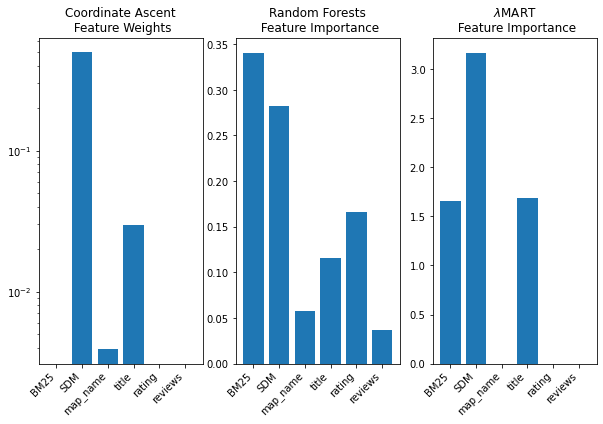

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt, numpy as np

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 6))

ax0.bar(np.arange(len(fnames)), ca_pipe[1].model.to_dict()['Linear']['weights'])
ax0.set_xticks(np.arange(len(fnames)))
ax0.set_xticklabels(fnames, rotation=45, ha='right')
ax0.set_title("Coordinate Ascent\n Feature Weights")
ax0.set_yscale('log')

ax1.bar(np.arange(len(fnames)), rf.feature_importances_)
ax1.set_xticks(np.arange(len(fnames)))
ax1.set_xticklabels(fnames, rotation=45, ha='right')
ax1.set_title("Random Forests\n Feature Importance")

ax2.bar(np.arange(len(fnames)), lmart_l.feature_importances_)
ax2.set_xticks(np.arange(len(fnames)))
ax2.set_xticklabels(fnames, rotation=45, ha='right')
ax2.set_title("$\lambda$MART\n Feature Importance")

fig.show()